We are two UIUC students from Indonesia that is attempting to predict air quality trends in Jakarta. 

## Importing Libraries

In [1257]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#from imblearn.combine import SMOTEENN

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours


## Cleaning The Data

In [1258]:
df = pd.read_csv('dataset/airquality-data.csv')
df.drop(columns=['periode_data'])
df

,periode_data,tanggal,pm_10,pm_duakomalima,so2,co,o3,no2,max,critical,categori,lokasi_spku
0,202212,2022-12-02,60,94,52,18,42,30,94,"PM2,5",SEDANG,DKI4
1,202212,2022-12-03,60,100,52,16,49,31,100,"PM2,5",SEDANG,DKI4
2,202212,2022-12-04,65,95,52,19,45,34,95,"PM2,5",SEDANG,DKI4
3,202212,2022-12-05,74,117,52,19,48,33,117,"PM2,5",TIDAK SEHAT,DKI4
4,202212,2022-12-06,70,107,49,24,41,44,107,"PM2,5",TIDAK SEHAT,DKI4
...,...,...,...,...,...,...,...,...,...,...,...,...
360,202201,2022-01-16,67,102,47,20,65,32,102,"PM2,5",TIDAK SEHAT,DKI5
361,202201,2022-01-15,55,69,51,15,68,29,69,"PM2,5",SEDANG,DKI3
362,202201,2022-01-14,46,63,48,15,63,32,63,"PM2,5",SEDANG,DKI2
363,202201,2022-01-13,38,62,52,15,63,32,63,O3,SEDANG,DKI2


Translating the Data

In [1259]:
translations = {
    'periode_data': 'Data Period',
    'tanggal' : 'Date',
    'pm_10' : 'PM 10',
    'so2' : 'SO2',
    'co' : 'CO',
    'o3' : 'O3',
    'no2' : 'NO2',
    'max' : 'Max',
    'critical' : 'Critical',
    'pm_duakomalima' : 'PM 2.5',
    'lokasi_spku' : 'Station Location',
    'categori' : 'Category'
}
df.rename(columns=translations, inplace=True)

category_translation = {
    'SEDANG': 'MODERATE',
    'TIDAK SEHAT' : 'POOR',
    'BAIK' : 'GOOD',
}
df['Category'] = df['Category'].replace(category_translation)

station_location_translation = {
    '0' : '0',
    'DKI1' : 'DKI1 (Bunderan HI)',
    'DKI2' : 'DKI2 (Kelapa Gading)',
    'DKI3' : 'DKI3 (Jagakarsa)',
    'DKI4' : 'DKI4 (Lubang Buaya)',
    'DKI5' : 'DKI5 (Kebon Jeruk)'
}

df['Station Location'] = df['Station Location'].replace(station_location_translation)
df

,Data Period,Date,PM 10,PM 2.5,SO2,CO,O3,NO2,Max,Critical,Category,Station Location
0,202212,2022-12-02,60,94,52,18,42,30,94,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
1,202212,2022-12-03,60,100,52,16,49,31,100,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
2,202212,2022-12-04,65,95,52,19,45,34,95,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
3,202212,2022-12-05,74,117,52,19,48,33,117,"PM2,5",POOR,DKI4 (Lubang Buaya)
4,202212,2022-12-06,70,107,49,24,41,44,107,"PM2,5",POOR,DKI4 (Lubang Buaya)
...,...,...,...,...,...,...,...,...,...,...,...,...
360,202201,2022-01-16,67,102,47,20,65,32,102,"PM2,5",POOR,DKI5 (Kebon Jeruk)
361,202201,2022-01-15,55,69,51,15,68,29,69,"PM2,5",MODERATE,DKI3 (Jagakarsa)
362,202201,2022-01-14,46,63,48,15,63,32,63,"PM2,5",MODERATE,DKI2 (Kelapa Gading)
363,202201,2022-01-13,38,62,52,15,63,32,63,O3,MODERATE,DKI2 (Kelapa Gading)


finding coordinate for each station

Translating category column

In [1260]:
df = df.sort_values(by = 'Date', ascending = True).reset_index(drop = True)
df

,Data Period,Date,PM 10,PM 2.5,SO2,CO,O3,NO2,Max,Critical,Category,Station Location
0,202202,2020-02-01,64,89,52,13,76,21,89,"PM2,5",MODERATE,DKI3 (Jagakarsa)
1,202202,2020-02-02,66,101,47,22,64,26,101,"PM2,5",POOR,DKI4 (Lubang Buaya)
2,202202,2020-02-03,58,99,48,20,65,33,99,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
3,202202,2020-02-04,54,72,46,12,68,27,72,"PM2,5",MODERATE,DKI3 (Jagakarsa)
4,202202,2020-02-05,43,62,53,18,55,30,62,"PM2,5",MODERATE,DKI5 (Kebon Jeruk)
...,...,...,...,...,...,...,...,...,...,...,...,...
360,202212,2022-12-27,36,47,58,42,20,18,58,SO2,MODERATE,DKI2 (Kelapa Gading)
361,202212,2022-12-28,46,66,57,41,15,19,66,"PM2,5",MODERATE,DKI3 (Jagakarsa)
362,202212,2022-12-29,23,50,57,12,16,15,57,SO2,MODERATE,DKI2 (Kelapa Gading)
363,202212,2022-12-30,40,64,57,21,17,24,64,"PM2,5",MODERATE,DKI4 (Lubang Buaya)


In [1261]:
# remove incorrect date data
df2 = df.drop(364)

# remove 2020 data
df3 = df2.drop(range(0,28))
df = df3
df

,Data Period,Date,PM 10,PM 2.5,SO2,CO,O3,NO2,Max,Critical,Category,Station Location
28,202201,2022-01-01,57,85,48,13,34,18,85,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
29,202201,2022-01-02,40,70,45,10,36,11,70,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
30,202201,2022-01-03,49,80,49,13,37,21,80,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
31,202201,2022-01-04,59,102,51,14,51,26,102,"PM2,5",POOR,DKI4 (Lubang Buaya)
32,202201,2022-01-05,95,165,53,18,55,32,165,"PM2,5",POOR,DKI4 (Lubang Buaya)
...,...,...,...,...,...,...,...,...,...,...,...,...
359,202212,2022-12-26,43,62,58,54,25,27,62,"PM2,5",MODERATE,DKI2 (Kelapa Gading)
360,202212,2022-12-27,36,47,58,42,20,18,58,SO2,MODERATE,DKI2 (Kelapa Gading)
361,202212,2022-12-28,46,66,57,41,15,19,66,"PM2,5",MODERATE,DKI3 (Jagakarsa)
362,202212,2022-12-29,23,50,57,12,16,15,57,SO2,MODERATE,DKI2 (Kelapa Gading)


In [1262]:
df.replace('null', np.NaN, inplace=True)
df

,Data Period,Date,PM 10,PM 2.5,SO2,CO,O3,NO2,Max,Critical,Category,Station Location
28,202201,2022-01-01,57,85,48,13,34,18,85,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
29,202201,2022-01-02,40,70,45,10,36,11,70,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
30,202201,2022-01-03,49,80,49,13,37,21,80,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
31,202201,2022-01-04,59,102,51,14,51,26,102,"PM2,5",POOR,DKI4 (Lubang Buaya)
32,202201,2022-01-05,95,165,53,18,55,32,165,"PM2,5",POOR,DKI4 (Lubang Buaya)
...,...,...,...,...,...,...,...,...,...,...,...,...
359,202212,2022-12-26,43,62,58,54,25,27,62,"PM2,5",MODERATE,DKI2 (Kelapa Gading)
360,202212,2022-12-27,36,47,58,42,20,18,58,SO2,MODERATE,DKI2 (Kelapa Gading)
361,202212,2022-12-28,46,66,57,41,15,19,66,"PM2,5",MODERATE,DKI3 (Jagakarsa)
362,202212,2022-12-29,23,50,57,12,16,15,57,SO2,MODERATE,DKI2 (Kelapa Gading)


## Understanding the data

In [1263]:
df.head()

,Data Period,Date,PM 10,PM 2.5,SO2,CO,O3,NO2,Max,Critical,Category,Station Location
28,202201,2022-01-01,57,85,48,13,34,18,85,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
29,202201,2022-01-02,40,70,45,10,36,11,70,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
30,202201,2022-01-03,49,80,49,13,37,21,80,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
31,202201,2022-01-04,59,102,51,14,51,26,102,"PM2,5",POOR,DKI4 (Lubang Buaya)
32,202201,2022-01-05,95,165,53,18,55,32,165,"PM2,5",POOR,DKI4 (Lubang Buaya)


In [1264]:
df.tail()

,Data Period,Date,PM 10,PM 2.5,SO2,CO,O3,NO2,Max,Critical,Category,Station Location
359,202212,2022-12-26,43,62,58,54,25,27,62,"PM2,5",MODERATE,DKI2 (Kelapa Gading)
360,202212,2022-12-27,36,47,58,42,20,18,58,SO2,MODERATE,DKI2 (Kelapa Gading)
361,202212,2022-12-28,46,66,57,41,15,19,66,"PM2,5",MODERATE,DKI3 (Jagakarsa)
362,202212,2022-12-29,23,50,57,12,16,15,57,SO2,MODERATE,DKI2 (Kelapa Gading)
363,202212,2022-12-30,40,64,57,21,17,24,64,"PM2,5",MODERATE,DKI4 (Lubang Buaya)


In [1265]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 28 to 363
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Data Period       336 non-null    int64 
 1   Date              336 non-null    object
 2   PM 10             336 non-null    int64 
 3   PM 2.5            336 non-null    int64 
 4   SO2               336 non-null    int64 
 5   CO                336 non-null    int64 
 6   O3                336 non-null    int64 
 7   NO2               336 non-null    int64 
 8   Max               336 non-null    int64 
 9   Critical          335 non-null    object
 10  Category          336 non-null    object
 11  Station Location  336 non-null    object
dtypes: int64(8), object(4)
memory usage: 31.6+ KB


In [1266]:
df.shape

(336, 12)

In [1267]:
df.describe()

,Data Period,PM 10,PM 2.5,SO2,CO,O3,NO2,Max
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,202206.886905,60.324405,93.717262,48.125000,18.383929,57.553571,28.791667,94.625000
std,3.319640,13.234018,24.416421,4.443593,7.170727,23.897857,8.710504,24.492628
min,202201.000000,23.000000,40.000000,37.000000,7.000000,15.000000,6.000000,50.000000
25%,202204.000000,53.000000,76.000000,45.000000,14.000000,39.000000,23.000000,76.000000
50%,202207.000000,60.000000,92.000000,49.000000,17.000000,53.000000,28.000000,93.000000
75%,202210.000000,69.250000,112.000000,51.000000,21.000000,72.250000,33.250000,112.000000
max,202212.000000,95.000000,165.000000,62.000000,55.000000,181.000000,52.000000,181.000000


In [1268]:

df = df[df.Critical != 'null']
df

,Data Period,Date,PM 10,PM 2.5,SO2,CO,O3,NO2,Max,Critical,Category,Station Location
28,202201,2022-01-01,57,85,48,13,34,18,85,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
29,202201,2022-01-02,40,70,45,10,36,11,70,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
30,202201,2022-01-03,49,80,49,13,37,21,80,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
31,202201,2022-01-04,59,102,51,14,51,26,102,"PM2,5",POOR,DKI4 (Lubang Buaya)
32,202201,2022-01-05,95,165,53,18,55,32,165,"PM2,5",POOR,DKI4 (Lubang Buaya)
...,...,...,...,...,...,...,...,...,...,...,...,...
359,202212,2022-12-26,43,62,58,54,25,27,62,"PM2,5",MODERATE,DKI2 (Kelapa Gading)
360,202212,2022-12-27,36,47,58,42,20,18,58,SO2,MODERATE,DKI2 (Kelapa Gading)
361,202212,2022-12-28,46,66,57,41,15,19,66,"PM2,5",MODERATE,DKI3 (Jagakarsa)
362,202212,2022-12-29,23,50,57,12,16,15,57,SO2,MODERATE,DKI2 (Kelapa Gading)


The dataset used in this model is taken from the Jakarta Open Data Website. It contains information about the Air Pollution Quality Index (APSI) measured by 5 air quality monitoring systems (AQMS) in the DKI Jakarta province for the year 2022.

Dataset components:

1. Date: Data of air quality measurement
2. PM 10: Particulate matter, one of the monitored parameters
3. PM 2.5: Particulate matter with a size below 2.5 microns, one of the monitored parameters
4. SO2: Sulfide, one of the monitored parameters
5. CO: Carbon Monoxide, one of the monitored parameters
6. O3: Ozone, one of the monitored parameters
7. NO2: Nitrogen dioxide, one of the monitored parameters
8. Max: Highest measurement value from all parameters measured at the same time
9. Critical: Parameter with the highest measurement value
10. Station Location: Air Quality Monitoring Systems Location

,Data Period,PM 10,PM 2.5,SO2,CO,O3,NO2,Max,Critical,Category,Station Location
Date,,,,,,,,,,,
2022-01-01,202201,57,85,48,13,34,18,85,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
2022-01-02,202201,40,70,45,10,36,11,70,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
2022-01-03,202201,49,80,49,13,37,21,80,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
2022-01-04,202201,59,102,51,14,51,26,102,"PM2,5",POOR,DKI4 (Lubang Buaya)
2022-01-05,202201,95,165,53,18,55,32,165,"PM2,5",POOR,DKI4 (Lubang Buaya)
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,202212,43,62,58,54,25,27,62,"PM2,5",MODERATE,DKI2 (Kelapa Gading)
2022-12-27,202212,36,47,58,42,20,18,58,SO2,MODERATE,DKI2 (Kelapa Gading)
2022-12-28,202212,46,66,57,41,15,19,66,"PM2,5",MODERATE,DKI3 (Jagakarsa)


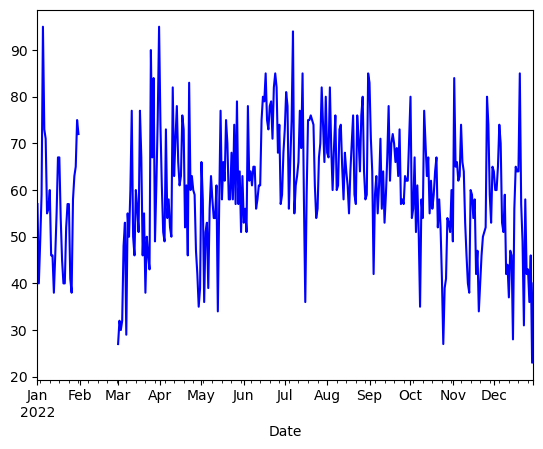

In [1269]:
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)
numerical_columns = df.select_dtypes(include=['number']).columns
df_resampled = df[numerical_columns].resample('D').mean()
df_resampled['PM 10'].plot(kind='line', color='blue')
df

# Handling Outliers

In [1270]:
df_numerical = df.reset_index().drop('Date', axis=1)
df_numerical = df.iloc[:,1:10]
# df_numerical = temp.drop(['Critical'], axis=1)
df_numerical

,PM 10,PM 2.5,SO2,CO,O3,NO2,Max,Critical,Category
Date,,,,,,,,,
2022-01-01,57,85,48,13,34,18,85,"PM2,5",MODERATE
2022-01-02,40,70,45,10,36,11,70,"PM2,5",MODERATE
2022-01-03,49,80,49,13,37,21,80,"PM2,5",MODERATE
2022-01-04,59,102,51,14,51,26,102,"PM2,5",POOR
2022-01-05,95,165,53,18,55,32,165,"PM2,5",POOR
...,...,...,...,...,...,...,...,...,...
2022-12-26,43,62,58,54,25,27,62,"PM2,5",MODERATE
2022-12-27,36,47,58,42,20,18,58,SO2,MODERATE
2022-12-28,46,66,57,41,15,19,66,"PM2,5",MODERATE


In [1271]:
def remove_outliers(df):
    df_noOutliers = df.copy()
    for i in df_noOutliers.columns:
        Q1 = df_noOutliers[i].quantile(0.25)
        Q3 = df_noOutliers[i].quantile(0.75)
        IQR = Q3-Q1

        upperBound = Q3 + (1.5*IQR) 
        lowerBound = Q1 - (1.5*IQR) 

        df_noOutliers = df_noOutliers[df_noOutliers[i] <= upperBound]
        df_noOutliers = df_noOutliers[df_noOutliers[i] >= lowerBound]

        df_noOutliers = df_noOutliers.reset_index(drop = True)
    return df_noOutliers

def percentageOf(value, totalValue):
    return (value / totalValue) * 100

In [1281]:
df_clean = remove_outliers(df)
df = df[df.index.isin(df_clean.index)]


TypeError: unsupported operand type(s) for -: 'str' and 'str'

# Changing Categorical data to numerical data

In [1272]:
df.Category.value_counts()

Category
MODERATE    207
POOR        128
GOOD          1
Name: count, dtype: int64

In [1273]:
mapping = {
    'GOOD': 0,
    'MODERATE' : 1,
    'POOR' : 2,
}
df['Target'] = df.Category.map(mapping)
df['Target'].value_counts()

Target
1    207
2    128
0      1
Name: count, dtype: int64

## Changing Target Variables

In [1274]:
df.columns

Index(['Data Period', 'PM 10', 'PM 2.5', 'SO2', 'CO', 'O3', 'NO2', 'Max',
       'Critical', 'Category', 'Station Location', 'Target'],
      dtype='object')

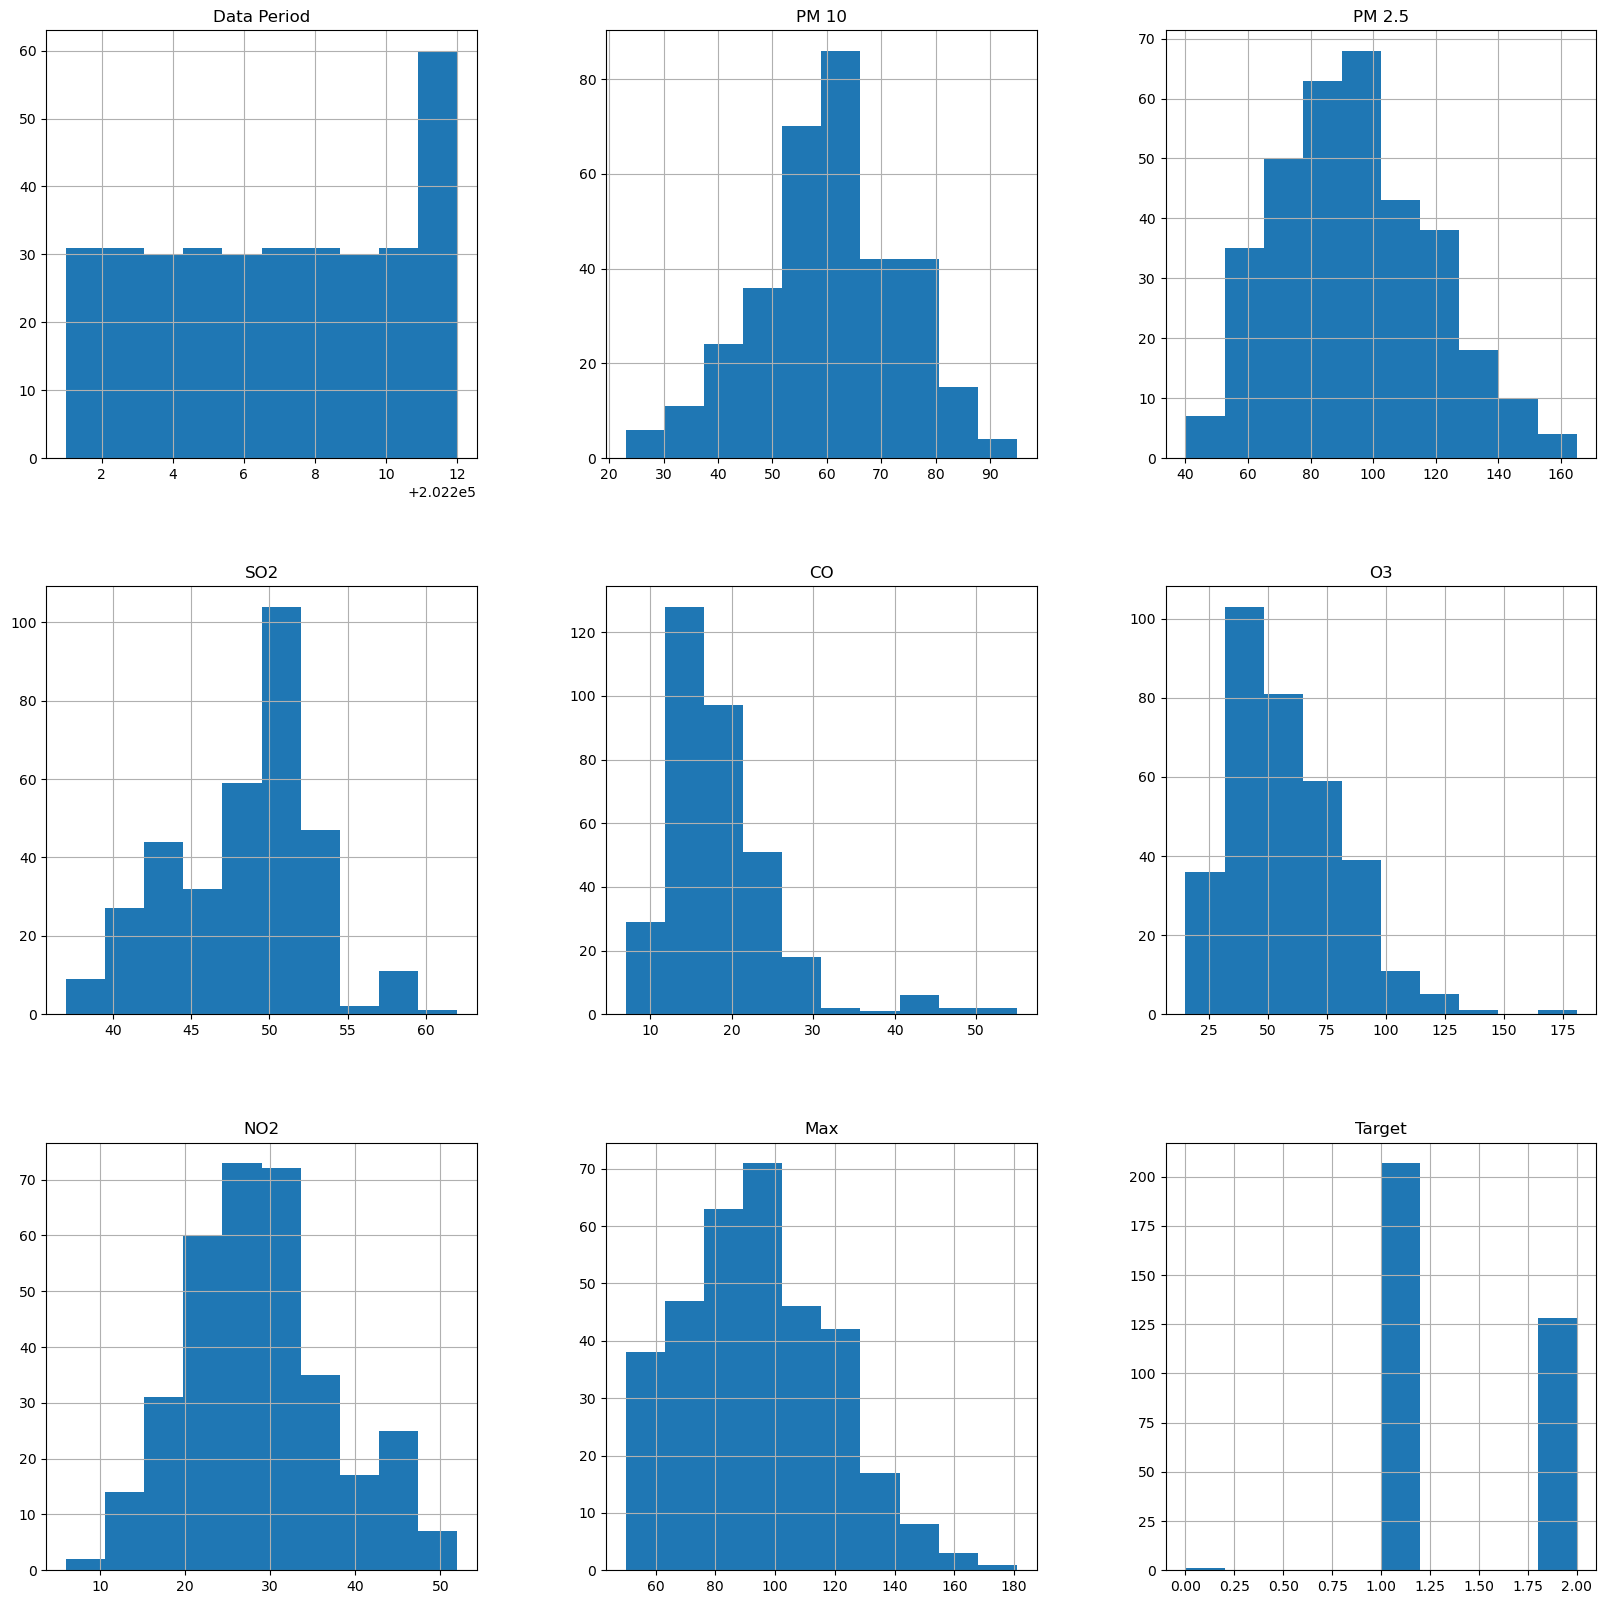

In [1275]:
plot = df.hist(figsize = (20,20))

In [1276]:
temp = df.reset_index().drop('Date', axis=1)
x = temp.drop(['Critical', 'Category', 'Target', 'Station Location', 'Data Period'], axis=1)
y = df['Target']
x

,PM 10,PM 2.5,SO2,CO,O3,NO2,Max
0,57,85,48,13,34,18,85
1,40,70,45,10,36,11,70
2,49,80,49,13,37,21,80
3,59,102,51,14,51,26,102
4,95,165,53,18,55,32,165
...,...,...,...,...,...,...,...
331,43,62,58,54,25,27,62
332,36,47,58,42,20,18,58
333,46,66,57,41,15,19,66
334,23,50,57,12,16,15,57


In [1277]:
x.head(5)

,PM 10,PM 2.5,SO2,CO,O3,NO2,Max
0,57,85,48,13,34,18,85
1,40,70,45,10,36,11,70
2,49,80,49,13,37,21,80
3,59,102,51,14,51,26,102
4,95,165,53,18,55,32,165


In [1278]:
y.head(5)

Date
2022-01-01    1
2022-01-02    1
2022-01-03    1
2022-01-04    2
2022-01-05    2
Name: Target, dtype: int64

In [1279]:
temporary_target = y.value_counts()

# percentages
moderate = (temporary_target[1] / len(y)) * 100
poor = (temporary_target[2] / len(y)) * 100
good = (temporary_target[0] / len(y)) * 100
total = moderate + poor + good

print(f"0: {good:.2f}%")
print(f"1: {moderate:.2f}%")
print(f"2: {poor:.2f}%")
print(f"Total: {total:.2f}%")


0: 0.30%
1: 61.61%
2: 38.10%
Total: 100.00%


In [1280]:
#sme = SMOTEENN(sampling_strategy='not majority', random_state=24)
#x_res, y_res = sme.fit_resample(x, y)
#y_res.value_counts()

enn = EditedNearestNeighbours(n_neighbors=1)
sme = SMOTEENN(sampling_strategy='all', random_state=24, enn=enn)
x_res, y_res = sme.fit_resample(x, y)

# Check the balance of the resampled dataset
print(y_res.value_counts())


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 1, n_neighbors = 6

SMOTEENN is a combination of SMOTE (Synthetic Minority Oversampling Technique) and ENN (Edited Nearest Neighbour). It is used to add synthetic data to the inside of the minority, while ENN is used to erase useless data from the majority. SMOTEENN is useful to increase the number of minorities without increasing the amount of data in the majority, while erasing unused data from the majority.

## Checking distribution after the sampling

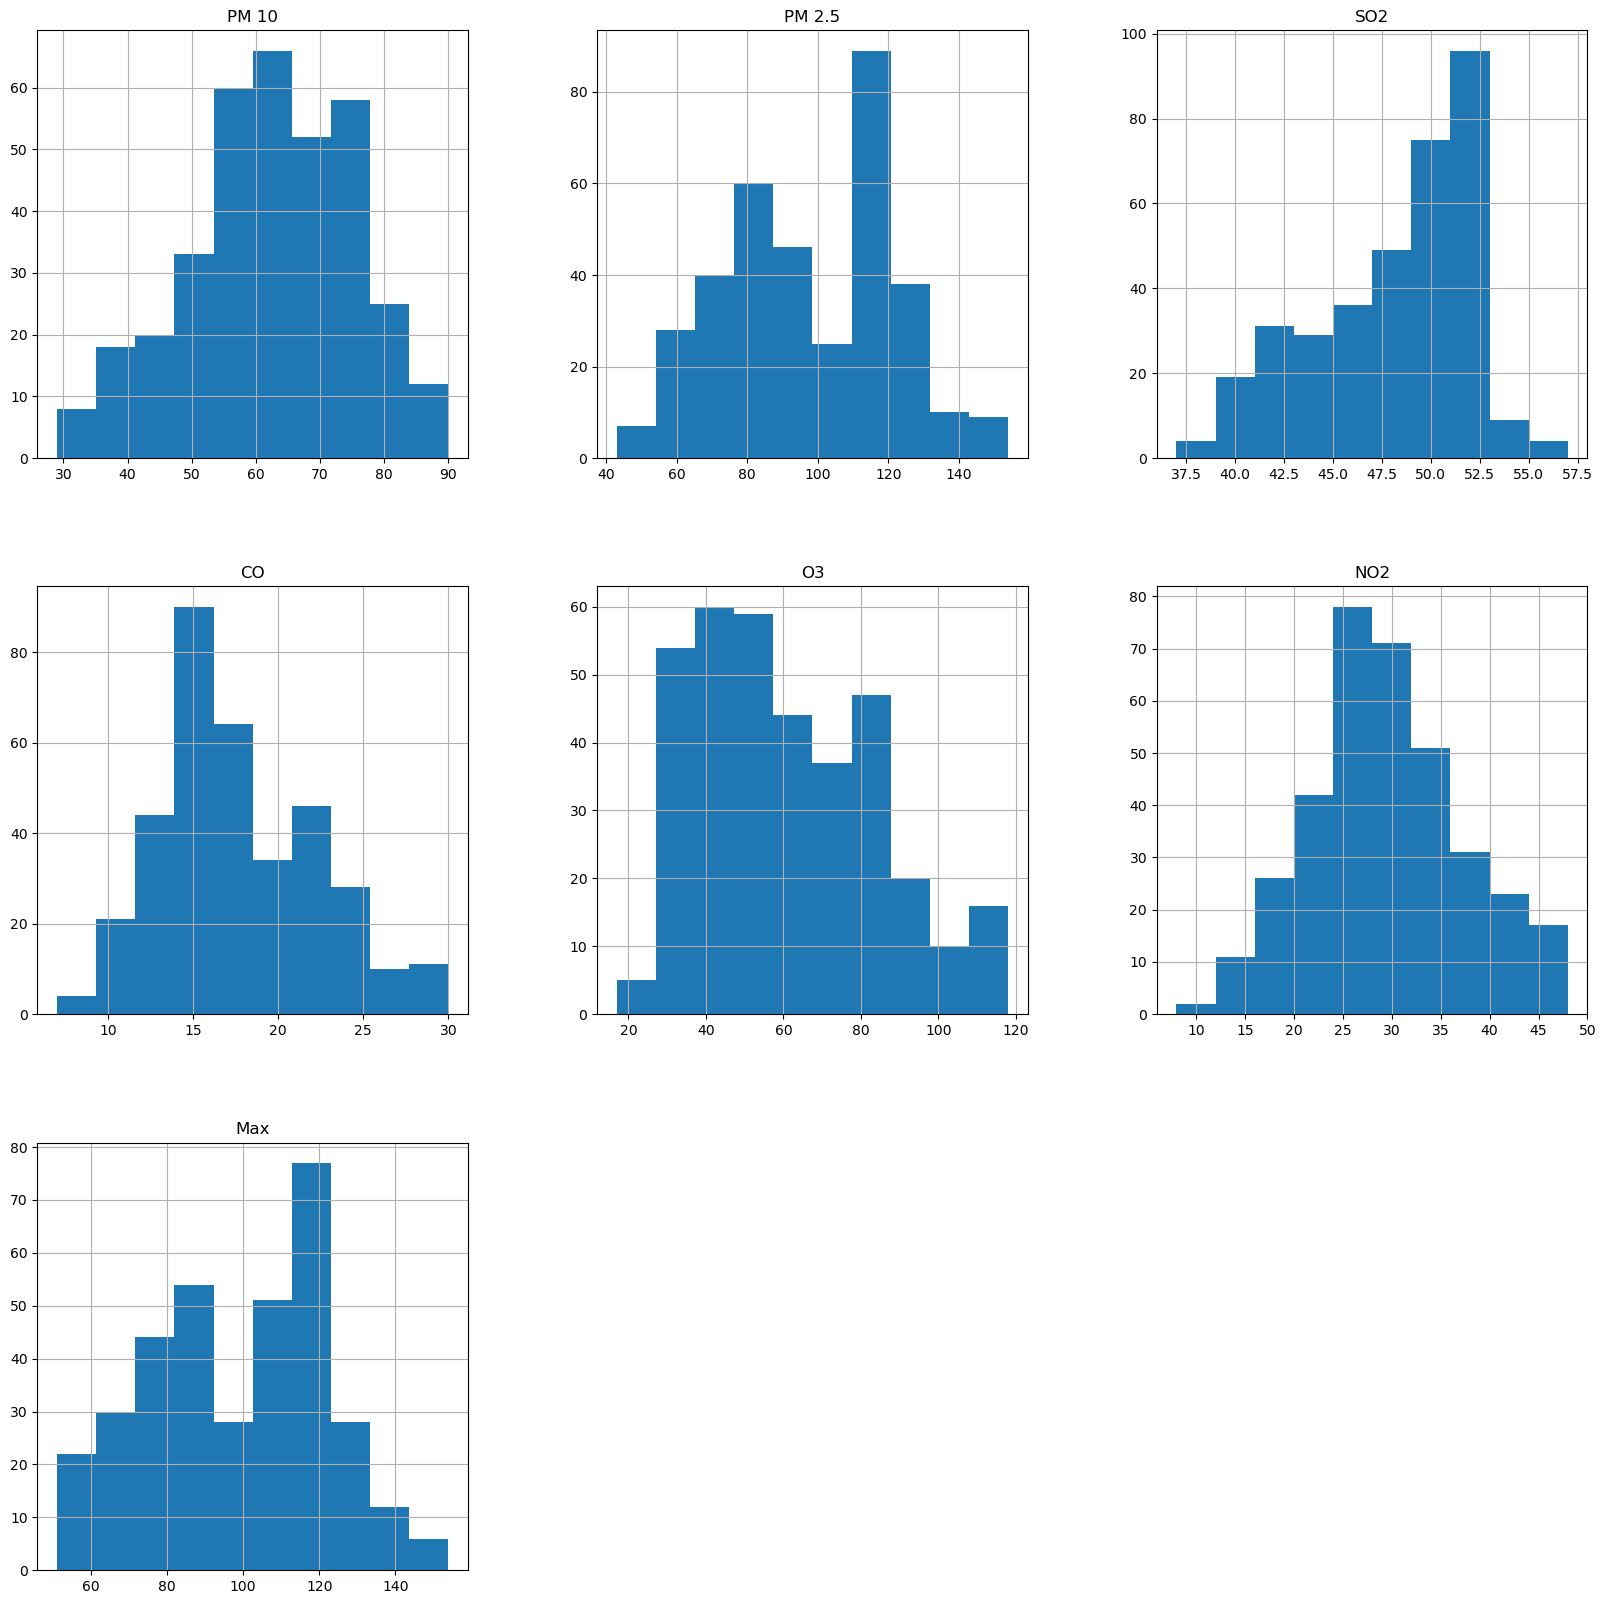

In [ ]:
plot = x_res.hist(figsize = (20,20))

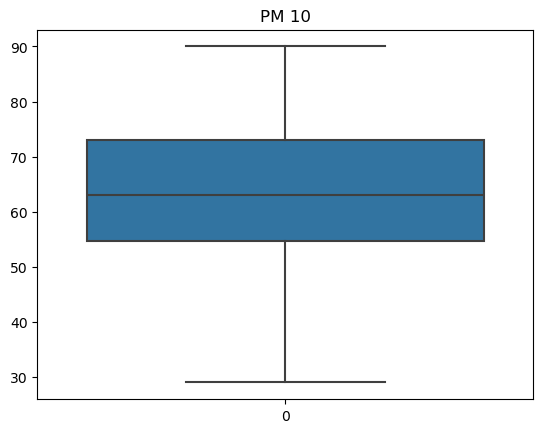

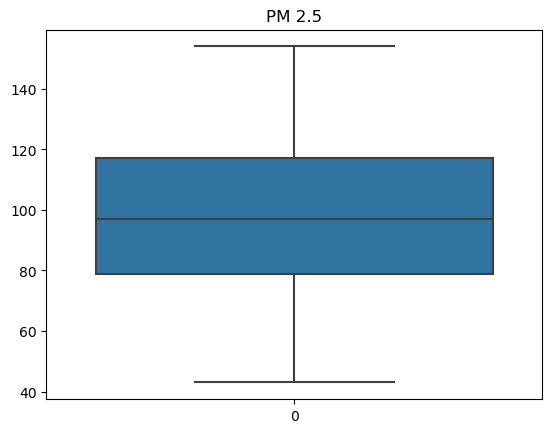

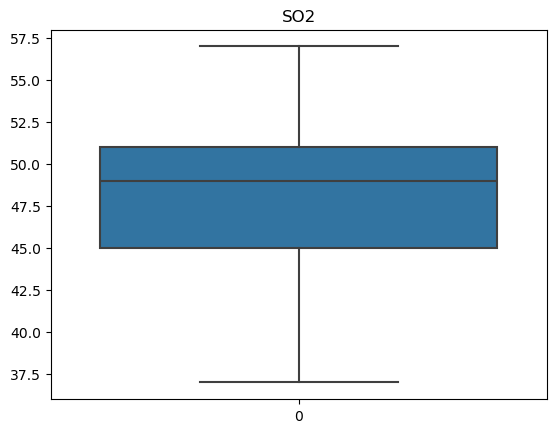

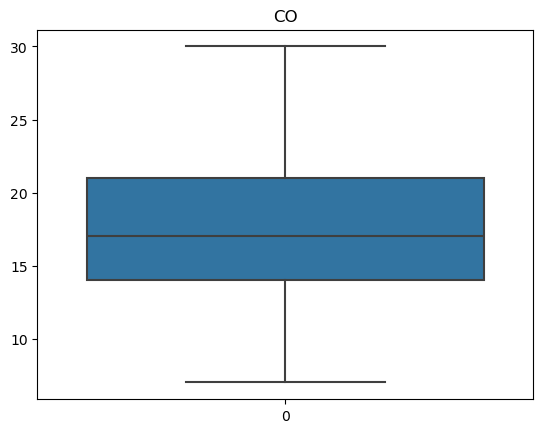

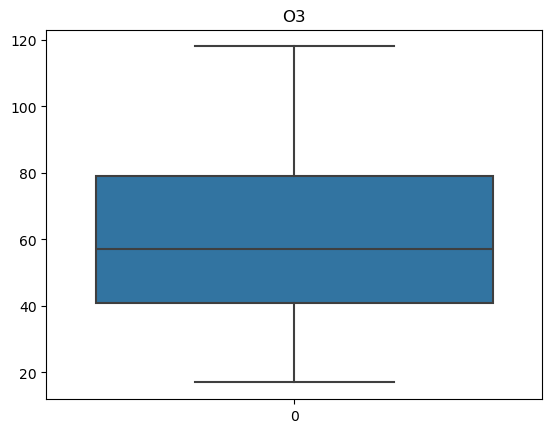

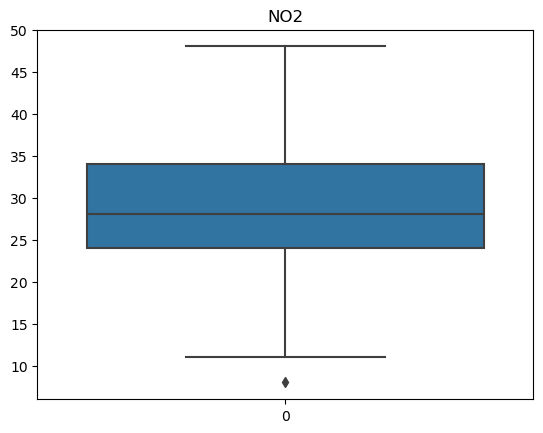

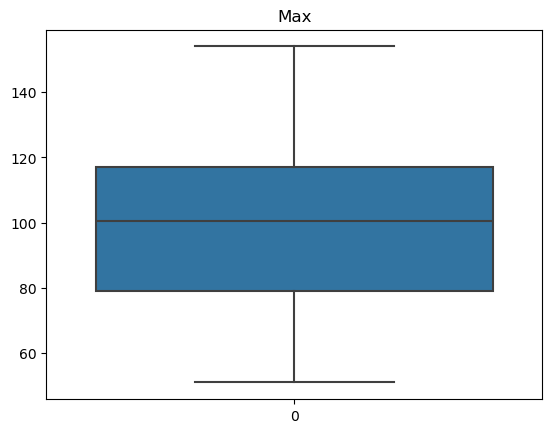

In [ ]:
for i in x_res.columns:
    sns.boxplot(data=x_res[i])
    plt.title(i)
    plt.show()

In [ ]:
x_res_noOutliers = remove_outliers(x_res)
print(len(x_res) - len(x_res_noOutliers))
print(len(x_res_noOutliers))

1
351


In [ ]:
y_res = y_res[y_res.index.isin(x_res_noOutliers.index)]

## Split data for training and testing

In [ ]:

x_train, x_test, y_train, y_test = train_test_split(x_res_noOutliers, y_res,  
                                                    shuffle = True,
                                                    test_size=0.2, 
                                                    random_state=24)
